In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip /content/drive/MyDrive/NLMH_Thuchanh/Week15_Thuchanh8/Dataset-Fruits-20230620.zip
# !unzip /content/apple.zip
# !unzip /content/banana.zip
# !unzip /content/orange.zip

In [ ]:
# import os
# import glob
# import pandas as pd
# import xml.etree.ElementTree as ET

# def xml_to_csv(path):
#     xml_list = []
#     for xml_file in glob.glob(path + '/*.xml'):
#         tree = ET.parse(xml_file)
#         root = tree.getroot()
#         for member in root.findall('object'):
#             bbx = member.find('bndbox')
#             xmin = int(bbx.find('xmin').text)
#             ymin = int(bbx.find('ymin').text)
#             xmax = int(bbx.find('xmax').text)
#             ymax = int(bbx.find('ymax').text)
#             label = member.find('name').text

#             value = (root.find('filename').text,
#                      int(root.find('size')[0].text),
#                      int(root.find('size')[1].text),
#                      label,
#                      xmin,
#                      ymin,
#                      xmax,
#                      ymax
#                      )
#             xml_list.append(value)
#     column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
#     xml_df = pd.DataFrame(xml_list, columns=column_name)
#     return xml_df

# def main():
#     datasets = ['orange']
#     for ds in datasets:
#         xml_df = xml_to_csv(ds)
#         xml_df.to_csv('labels_{}.csv'.format(ds), index=None)
#         print('Successfully converted xml to csv.')

# main()

**CÁC BƯỚC XÂY DỰNG MÔ HÌNH**

Bước 1: Sử dụng VGG16 (được đào tạo trước trên ImageNet) và xóa đầu fully-connected (FC)

Bước 2: Xây dựng lớp Fully connected (FC) mới

Bước 3: Đặt lớp FC mới lên VGG16

Bước 4: Tinh chỉnh toàn bộ mạng để phát hiện đối tượng

**CẤU TRÚC THƯ MỤC**

```
MSSV
├── dataset
│   ├── annotations
│   │   ├── apple.csv
│   │   ├── banana.csv
│   │   └── orange.csv
│   └── images
│       ├── apple [70 entries]
│       ├── banana [70 entries]
│       └── orange [70 entries]
└── output
    ├── plots
    │   ├── accs.png
    │   └── losses.png
    ├── detector.h5
    └── lb.pickle
```

# **THIẾT LẬP CÁC THAM SỐ**

In [ ]:
# import the necessary packages
import os
# define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files
BASE_PATH = "/content/drive/MyDrive/NLMH_Thuchanh/Week15_Thuchanh8/21022008/dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])

In [ ]:
BASE_PATH

'/content/drive/MyDrive/NLMH_Thuchanh/Week15_Thuchanh8/21022008/dataset'

In [ ]:
# define the path to the base output directory
BASE_OUTPUT = "/content/drive/MyDrive/NLMH_Thuchanh/Week15_Thuchanh8/21022008/output"
# define the path to the output model, label binarizer, plots output
# directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
LB_PATH = os.path.sep.join([BASE_OUTPUT, "lb.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [ ]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 50
BATCH_SIZE = 32

# **HUẤN LUYỆN MÔ HÌNH**

## **Import thư viện**

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer # Đơn giản
from sklearn.model_selection import train_test_split # Tách tập train, test
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

## **Load dữ liệu**

In [ ]:
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths

# 4 mãng
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

[INFO] loading dataset...


In [ ]:
# loop over all CSV files in the annotations directory
for csvPath in paths.list_files(ANNOTS_PATH, validExts=(".csv")):
	# load the contents of the current CSV annotations file
	rows = open(csvPath).read().strip().split("\n")
	# loop over the rows
	for row in rows:
		# break the row into the filename, bounding box coordinates,
		# and class label
		row = row.split(",")
		(filename, startX, startY, endX, endY, label) = row
		# derive the path to the input image, load the image (in
		# OpenCV format), and grab its dimensions
		imagePath = os.path.sep.join([IMAGES_PATH, label,
			filename])
		image = cv2.imread(imagePath)
		(h, w) = image.shape[:2]
		# scale the bounding box coordinates relative to the spatial
		# dimensions of the input image
		# Trích xuất tọa độ
		startX = float(startX) / w
		startY = float(startY) / h
		endX = float(endX) / w
		endY = float(endY) / h
		# load the image and preprocess it
		image = load_img(imagePath, target_size=(224, 224)) # Kích thước chuẩn hay sử dụng
		image = img_to_array(image)
		# update our list of data, class labels, bounding boxes, and
		# image paths
		data.append(image) # Thêm dữ liệu
		labels.append(label)
		bboxes.append((startX, startY, endX, endY))
		imagePaths.append(imagePath)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# **Chuẩn hóa dữ liệu**

In [ ]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# only there are only two labels in the dataset, then we need to use
# Keras/TensorFlow's utility function as well
if len(lb.classes_) == 2: # Mặt định 2 chiều
	labels = to_categorical(labels)

## **Phân chia dữ liệu**

In [ ]:
from sklearn.model_selection import train_test_split
import os

split = train_test_split(data, labels, bboxes, imagePaths,test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")

# Check if the file exists before trying to remove it
if os.path.exists(TEST_PATHS):
    os.remove(TEST_PATHS)

f = open(TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()

[INFO] saving testing image paths...


## **Xây dựng mô hình**

In [ ]:
model = []

# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
vgg.trainable = False # Không lấy hàm phân loại VGG19
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label

# Kiến tạo mô hình
model = Model(inputs=vgg.input,outputs=(bboxHead, softmaxHead))

80134624/80134624 [==============================] - 0s 0us/step


## **Xác định loss và compile mô hình**

In [ ]:
losses = {"class_label": "categorical_crossentropy","bounding_box": "mean_squared_error",}
lossWeights = {	"class_label": 1.0,	"bounding_box": 1.0}
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

## **Huấn luyện mô hình**

In [ ]:
trainTargets = {"class_label": trainLabels,"bounding_box": trainBBoxes}
testTargets = {	"class_label": testLabels,"bounding_box": testBBoxes}

In [ ]:
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

# serialize the model to disk - Save model
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")

# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
Epoch 1/50
10/10 [==============================] - 19s 430ms/step - loss: 3.8056 - bounding_box_loss: 0.0835 - class_label_loss: 3.7221 - bounding_box_accuracy: 0.4749 - class_label_accuracy: 0.4381 - val_loss: 2.8835 - val_bounding_box_loss: 0.0779 - val_class_label_loss: 2.8056 - val_bounding_box_accuracy: 0.5467 - val_class_label_accuracy: 0.4400
Epoch 2/50
10/10 [==============================] - 2s 178ms/step - loss: 2.4950 - bounding_box_loss: 0.0773 - class_label_loss: 2.4176 - bounding_box_accuracy: 0.5686 - class_label_accuracy: 0.5652 - val_loss: 0.3677 - val_bounding_box_loss: 0.0783 - val_class_label_loss: 0.2894 - val_bounding_box_accuracy: 0.5733 - val_class_label_accuracy: 0.9067
Epoch 3/50
10/10 [==============================] - 2s 181ms/step - loss: 1.0312 - bounding_box_loss: 0.0767 - class_label_loss: 0.9545 - bounding_box_accuracy: 0.5753 - class_label_accuracy: 0.7659 - val_loss: 0.3777 - val_bounding_box_loss: 0.0796 - val_class_label_lo

## **Hiển thị loss và accuracy**

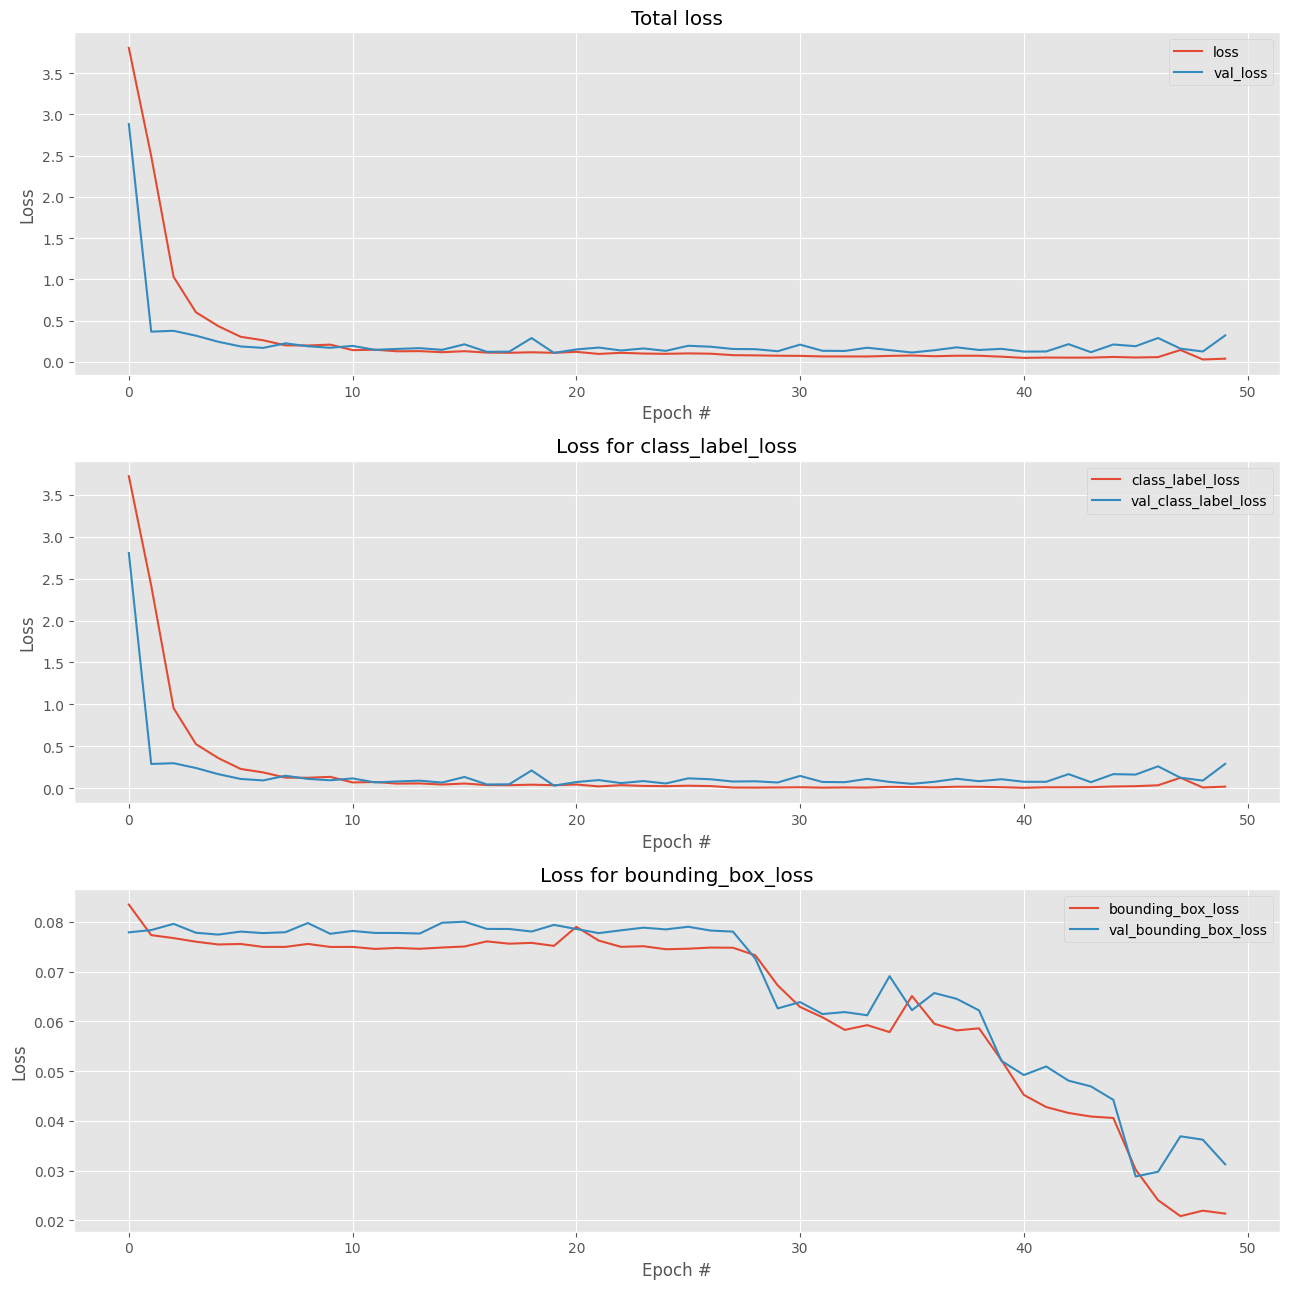

In [ ]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()

# save the losses figure and create a new figure for the accuracies
# Tạo ra thư mục nếu nó chưa tồn tại
if not os.path.exists(PLOTS_PATH):
    os.makedirs(PLOTS_PATH)

plt.tight_layout()
plotPath = os.path.sep.join([PLOTS_PATH, "losses.png"])
plt.savefig(plotPath)
# plt.close()

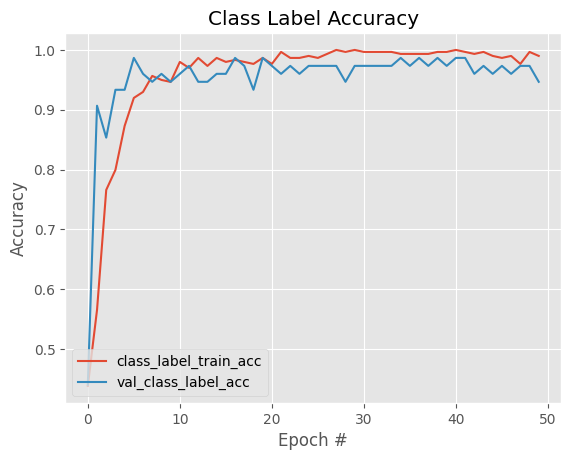

In [ ]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# save the accuracies plot
if not os.path.exists(PLOTS_PATH):
    os.makedirs(PLOTS_PATH)

plotPath = os.path.sep.join([PLOTS_PATH, "accs.png"])
plt.savefig(plotPath)

3/3 [==============================] - 0s 167ms/step


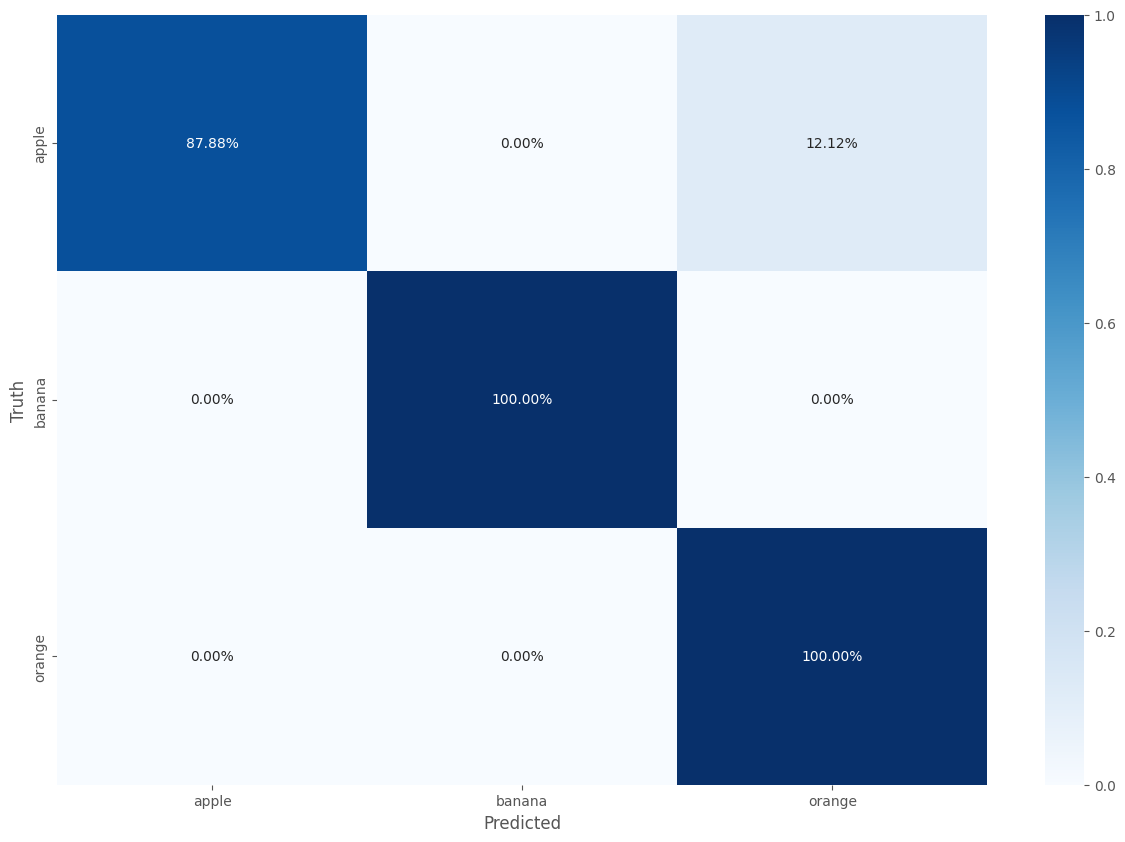

In [ ]:
# Get class names from the LabelBinarizer
class_names = lb.classes_

# Create the confusion matrix as before
Y_pred = model.predict(testImages)
Y_pred_classes = np.argmax(Y_pred[1], axis=1)
Y_true = np.argmax(testTargets["class_label"], axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# When calling heatmap, pass class names to the xticklabels and yticklabels arguments
plt.figure(figsize=(15,10))
sns.heatmap(confusion_mtx_percent, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


## **KIỂM THỬ MÔ HÌNH**

## **Import thư viện**

In [ ]:
from google.colab.patches import cv2_imshow
# import the necessary packages
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os

## **Load mô hình**

In [ ]:
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH)

[INFO] loading object detector...


## **Dự đoán hình ảnh bất kỳ**

1/1 [==============================] - 1s 849ms/step


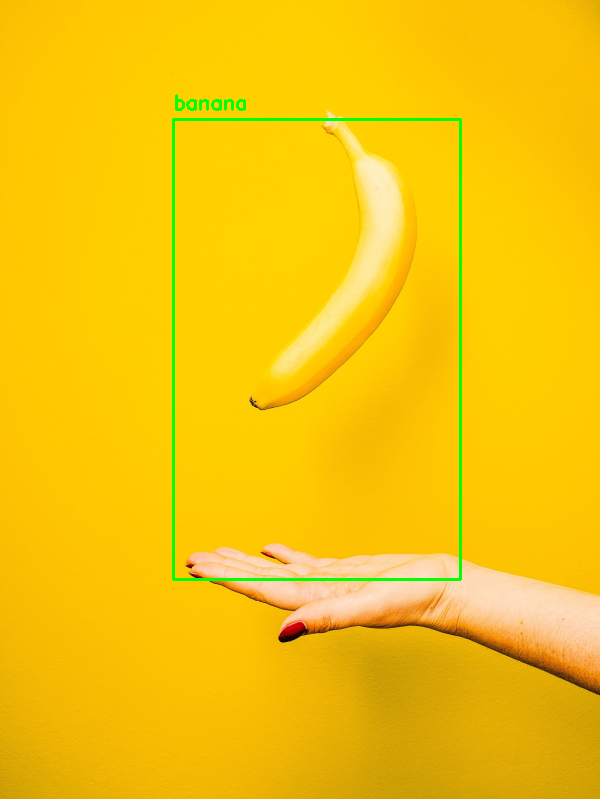

In [ ]:
image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
# make bounding box predictions on the input image
(boxPreds, labelPreds) = model.predict(image)
(startX, startY, endX, endY) = boxPreds[0]
# load the input image (in OpenCV format), resize it such that it
# fits on our screen, and grab its dimensions
image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
# Draw the predicted bounding box
i = np.argmax(labelPreds, axis=1)
label = lb.classes_[i][0]
y = startY - 10 if startY - 10 > 10 else startY + 10
cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
# Hiển thị hình ảnh
cv2_imshow(image)

[INFO] đang tải mô hình...
1/1 [==============================] - 0s 188ms/step


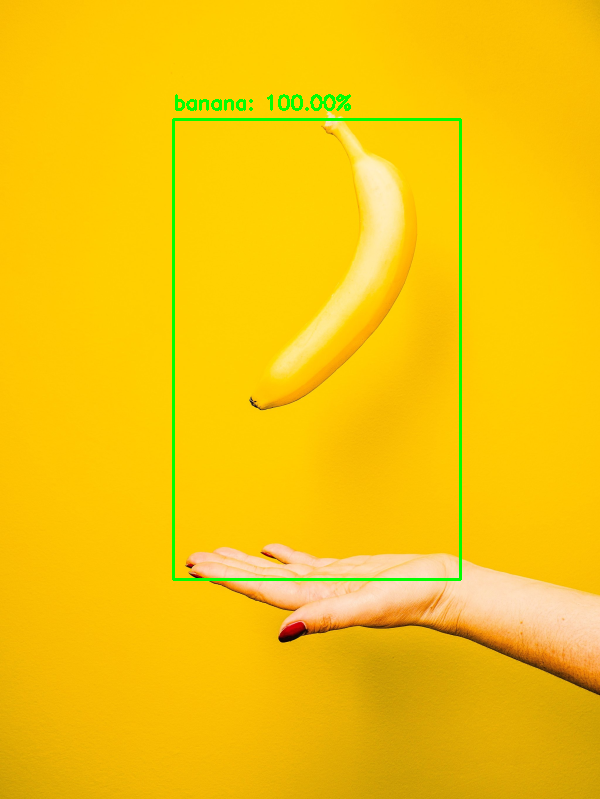

In [ ]:
# Tải mô hình từ đường dẫn đã cho
print("[INFO] đang tải mô hình...")
model = load_model(MODEL_PATH)

# Tải và tiền xử lý hình ảnh
image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

# Dự đoán tọa độ bounding box và nhãn cho hình ảnh đầu vào
(boxPreds, labelPreds) = model.predict(image)
(startX, startY, endX, endY) = boxPreds[0]

# Tải hình ảnh đầu vào (định dạng OpenCV), thay đổi kích thước sao cho
# nó phù hợp với màn hình, và lấy các chiều của nó
image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# Chuyển đổi tọa độ bounding box dự đoán dựa trên chiều của hình ảnh
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

# Lấy nhãn với xác suất cao nhất
i = np.argmax(labelPreds, axis=1)
label = lb.classes_[i][0]

# Lấy xác suất cho nhãn này
prob = np.max(labelPreds, axis=1)

# Định dạng là phần trăm và thêm vào nhãn
label = "{}: {:.2f}%".format(label, prob[0] * 100)  # Chỉnh sửa ở đây

# Vẽ bounding box và nhãn dự đoán lên hình ảnh
cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)

# Hiển thị hình ảnh
cv2_imshow(image)


In [ ]:
img_path_test = ["/content/drive/MyDrive/NLMH_Thuchanh/Week15_Thuchanh8/21022008/Q0Eimage.png",
                "/content/drive/MyDrive/NLMH_Thuchanh/Week15_Thuchanh8/21022008/tehimage.png"]

[INFO] đang tải mô hình...


1/1 [==============================] - 0s 192ms/step


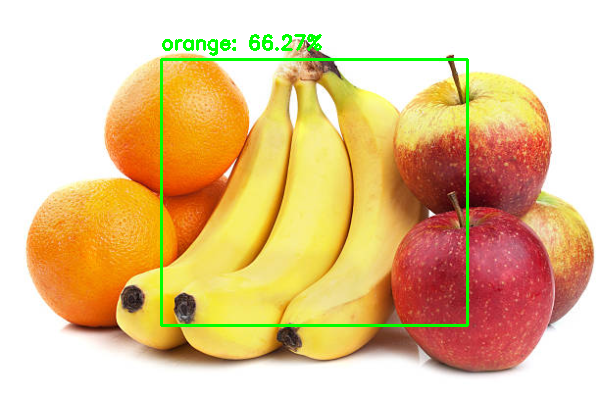

1/1 [==============================] - 0s 19ms/step


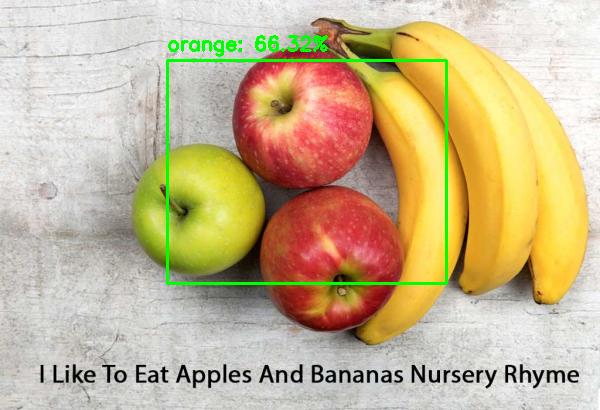

In [ ]:
# Tải mô hình từ đường dẫn đã cho
print("[INFO] đang tải mô hình...")
model = load_model(MODEL_PATH)

# Duyệt qua mỗi hình ảnh trong danh sách
for imagePath in img_path_test:
    # Tải và tiền xử lý hình ảnh
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # Dự đoán tọa độ bounding box và nhãn cho hình ảnh đầu vào
    (boxPreds, labelPreds) = model.predict(image)
    (startX, startY, endX, endY) = boxPreds[0]

    # Tải hình ảnh đầu vào (định dạng OpenCV), thay đổi kích thước sao cho
    # nó phù hợp với màn hình, và lấy các chiều của nó
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]

    # Chuyển đổi tọa độ bounding box dự đoán dựa trên chiều của hình ảnh
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # Lấy nhãn với xác suất cao nhất
    i = np.argmax(labelPreds, axis=1)
    label = lb.classes_[i][0]

    # Lấy xác suất cho nhãn này
    prob = np.max(labelPreds, axis=1)

    # Định dạng là phần trăm và thêm vào nhãn
    label = "{}: {:.2f}%".format(label, prob[0] * 100)

    # Vẽ bounding box và nhãn dự đoán lên hình ảnh
    cv2.putText(image, label, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
    cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)

    # Hiển thị hình ảnh
    cv2_imshow(image)


**1. Thực hiện training với tập dữ liệu đã được gán nhãn ở phần 1 với số lượng epochs là 50**

**2. Thực hiện vẽ biểu đồ loss - accuracy - confusion matrix cho mạng VGG19**

**3. Thực hiện training với tập dữ liệu với mạng InceptionV3, epochs 50 và lưu tên mô hình sau khi huấn luyện là MSSV_Incep.h5**

**4. Sử dụng hình ảnh bên dưới và thực hiện dự đoán với 2 mô hình vừa đào tạo**

**5. Hiển thị label và chỉ số độ chính xác trên hình ảnh dự đoán như ảnh bên dưới với 2 hình ở câu 4**